In [1]:
# ============================================
# 0. Install packages (Colab)
# ============================================
!pip install timm pandas opencv-python scikit-learn tqdm

In [2]:
# ============================================
# 1. Imports and setup
# ============================================
import os
import cv2
import numpy as np
import pandas as pd
from collections import defaultdict

from google.colab import drive
drive.mount('/content/drive')

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from PIL import Image
from glob import glob

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import timm
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import random

Mounted at /content/drive


In [3]:
# ============================================
# 2. Reproducibility
# ============================================
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [4]:
# ============================================
# 3. Paths and Excel labels
# ============================================
BASE_DIR   = "/content/drive/My Drive/Colab Notebooks"
IMG_DIR    = os.path.join(BASE_DIR, "Giemsa stained images")   # RGB images
MASK_DIR   = os.path.join(BASE_DIR, "Ground truth images")     # Binary masks
EXCEL_PATH = os.path.join(BASE_DIR, "LifeStages.xlsx")         # Stage labels

print("IMG_DIR   :", IMG_DIR)
print("MASK_DIR  :", MASK_DIR)
print("EXCEL_PATH:", EXCEL_PATH)

df = pd.read_excel(EXCEL_PATH)

# Drop optional index column if present
if 'Unnamed: 0' in df.columns:
    df = df.drop(columns=['Unnamed: 0'])

print("Columns:", df.columns.tolist())
df.head()

IMG_DIR   : /content/drive/My Drive/Colab Notebooks/Giemsa stained images
MASK_DIR  : /content/drive/My Drive/Colab Notebooks/Ground truth images
EXCEL_PATH: /content/drive/My Drive/Colab Notebooks/LifeStages.xlsx
Columns: ['imageName', 'stage', 'center_x', 'center_y']


/usr/local/lib/python3.12/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


,imageName,stage,center_x,center_y
0,Trip 017 Day 1 19-10-05 Image 14 add_10.png,Esch,457,603
1,Trip 017 Day 1 19-10-05 Image 16 add_15.png,Esch,1241,276
2,Trip 017 Day 1 19-10-05 Image 14 add_1.png,Esch,726,763
3,Trip 017 Day 1 19-10-05 Image 15 add_16.png,Esch,281,809
4,Trip 017 Day 1 19-10-05 Image 15 add_16.png,Esch,821,794


In [5]:
# ============================================
# 4. Helper functions to find RGB and mask
# ============================================
def find_image_path(folder, base_name):
    """
    Try to find the actual image file in the dataset, given the base name.
    """
    candidates = [
        base_name,
        base_name + ".png",
        base_name + ".jpg",
        base_name + ".jpeg",
        base_name + ".tif",
        base_name + ".tiff",
    ]
    for c in candidates:
        path = os.path.join(folder, c)
        if os.path.exists(path):
            return path
    return None


def find_mask_path(folder, base_name):
    """
    Find ground truth mask corresponding to an image.
    Handles '_GT.png' suffix and spacing.
    """
    if not base_name.lower().endswith(".png"):
        base_name = base_name + ".png"

    stem = base_name[:-4]  # remove .png

    candidates = [
        base_name,                      # exact name
        stem + "_GT.png",               # ground truth suffix
        stem + "_gt.png",
        stem.replace(" ", "_") + "_GT.png",
    ]

    for c in candidates:
        path = os.path.join(folder, c)
        if os.path.exists(path):
            return path
    return None

In [6]:
# ============================================
# 5. Crop parasites from masks (runs once)
#    CROPS_DIR will contain folders per stage.
# ============================================
df["imageName"] = df["imageName"].astype(str)
grouped = df.groupby("imageName")

CROPS_DIR = "/content/drive/MyDrive/processed_parasites_mask"
os.makedirs(CROPS_DIR, exist_ok=True)
stats_per_stage = defaultdict(int)

# If crops already exist, skip reprocessing
if os.path.exists(CROPS_DIR) and len(os.listdir(CROPS_DIR)) > 0:
    print("CROPS_DIR is not empty. Skipping data preprocessing.")
    for stage_folder in os.listdir(CROPS_DIR):
        stage_path = os.path.join(CROPS_DIR, stage_folder)
        if os.path.isdir(stage_path):
            stats_per_stage[stage_folder] = len(os.listdir(stage_path))
    print("Crops per stage (from existing data):", dict(stats_per_stage))
else:
    MIN_AREA = 20
    PADDING  = 5

    missing_rgb   = 0
    missing_mask  = 0
    components_without_match = 0

    for image_name, group in tqdm(grouped, desc="Extracting parasite patches"):
        img_path  = find_image_path(IMG_DIR,  image_name)
        mask_path = find_mask_path(MASK_DIR, image_name)

        if img_path is None:
            missing_rgb += 1
            continue
        if mask_path is None:
            missing_mask += 1
            continue

        img  = cv2.imread(img_path)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        if img is None or mask is None:
            continue

        # Binarize mask
        _, mask_bin = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)

        num_labels, labels, CC_stats, centroids = cv2.connectedComponentsWithStats(mask_bin)

        group = group.reset_index(drop=True)
        used_rows = set()

        for label in range(1, num_labels):
            x, y, bw, bh, area = CC_stats[label]
            if area < MIN_AREA:
                continue

            cx, cy = centroids[label]

            # Match centroid to closest excel annotation
            best_idx, best_dist2 = None, None
            for i, row in group.iterrows():
                if i in used_rows:
                    continue
                dx = cx - row["center_x"]
                dy = cy - row["center_y"]
                dist2 = dx*dx + dy*dy
                if best_dist2 is None or dist2 < best_dist2:
                    best_dist2 = dist2
                    best_idx = i

            if best_idx is None:
                components_without_match += 1
                continue

            used_rows.add(best_idx)
            stage = str(group.loc[best_idx, "stage"])

            x1 = max(0, x - PADDING)
            y1 = max(0, y - PADDING)
            x2 = min(img.shape[1], x + bw + PADDING)
            y2 = min(img.shape[0], y + bh + PADDING)

            crop = img[y1:y2, x1:x2]

            stage_dir = os.path.join(CROPS_DIR, stage)
            os.makedirs(stage_dir, exist_ok=True)

            filename = f"{os.path.splitext(os.path.basename(img_path))[0]}_cc{label}.png"
            cv2.imwrite(os.path.join(stage_dir, filename), crop)

            stats_per_stage[stage] += 1

    print("\n✅ Cropping finished")
    print("Missing RGB images:", missing_rgb)
    print("Missing masks:",     missing_mask)
    print("Unmatched components:", components_without_match)
    print("Crops per stage:", dict(stats_per_stage))

CROPS_DIR is not empty. Skipping data preprocessing.
Crops per stage (from existing data): {'Esch': 695, 'MT': 328, 'Seg': 200, 'R': 518, 'LR-ET': 303, 'Lsch': 439, 'DEBRIS': 683, 'LT': 363, 'WBC': 43, 'Gam': 2}


In [7]:
# ============================================
# 6. Build list of image paths and labels
#    using CROPS_DIR folders
# ============================================
stage_names = sorted(next(os.walk(CROPS_DIR))[1])  # list of folder names
label_map = {stage: i for i, stage in enumerate(stage_names)}
num_classes = len(label_map)

print("Stage names:", stage_names)
print("Label map:", label_map)
print("Number of classes:", num_classes)

all_paths = []
all_labels = []

for stage in stage_names:
    stage_folder = os.path.join(CROPS_DIR, stage)
    paths = glob(os.path.join(stage_folder, "*.png"))
    all_paths.extend(paths)
    all_labels.extend([label_map[stage]] * len(paths))

all_paths = np.array(all_paths)
all_labels = np.array(all_labels)

print("Total images:", len(all_paths))

Stage names: ['DEBRIS', 'Esch', 'Gam', 'LR-ET', 'LT', 'Lsch', 'MT', 'R', 'Seg', 'WBC']
Label map: {'DEBRIS': 0, 'Esch': 1, 'Gam': 2, 'LR-ET': 3, 'LT': 4, 'Lsch': 5, 'MT': 6, 'R': 7, 'Seg': 8, 'WBC': 9}
Number of classes: 10
Total images: 3574


In [8]:
# ============================================
# 7. Stratified split: 70% train, 15% val, 15% test
#    (second split not stratified to avoid rare-class error)
# ============================================
train_paths, temp_paths, train_labels, temp_labels = train_test_split(
    all_paths, all_labels,
    test_size=0.30,        # 30% -> val+test
    stratify=all_labels,
    random_state=42
)

val_paths, test_paths, val_labels, test_labels = train_test_split(
    temp_paths, temp_labels,
    test_size=0.50,        # 15% val, 15% test total
    stratify=None,
    random_state=42
)

print("Train size:", len(train_paths))
print("Val size  :", len(val_paths))
print("Test size :", len(test_paths))

# Quick sanity check: class distribution
def count_labels(labels, name):
    unique, counts = np.unique(labels, return_counts=True)
    print(f"\n{name} label counts:")
    for u, c in zip(unique, counts):
        print(f"  {u} ({stage_names[u]}): {c}")

count_labels(train_labels, "Train")
count_labels(val_labels,   "Val")
count_labels(test_labels,  "Test")

Train size: 2501
Val size  : 536
Test size : 537

Train label counts:
  0 (DEBRIS): 478
  1 (Esch): 486
  2 (Gam): 1
  3 (LR-ET): 212
  4 (LT): 254
  5 (Lsch): 307
  6 (MT): 230
  7 (R): 363
  8 (Seg): 140
  9 (WBC): 30

Val label counts:
  0 (DEBRIS): 105
  1 (Esch): 111
  2 (Gam): 1
  3 (LR-ET): 46
  4 (LT): 53
  5 (Lsch): 64
  6 (MT): 50
  7 (R): 73
  8 (Seg): 28
  9 (WBC): 5

Test label counts:
  0 (DEBRIS): 100
  1 (Esch): 98
  3 (LR-ET): 45
  4 (LT): 56
  5 (Lsch): 68
  6 (MT): 48
  7 (R): 82
  8 (Seg): 32
  9 (WBC): 8


In [9]:
# ============================================
# 8. Data augmentation / transforms
# ============================================
train_tf = T.Compose([
    T.RandomResizedCrop(224, scale=(0.8, 1.0)),
    T.RandomHorizontalFlip(),
    T.RandomVerticalFlip(),
    T.RandomRotation(20),
    T.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.2, hue=0.05),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406],
                [0.229, 0.224, 0.225]),
])

test_tf = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406],
                [0.229, 0.224, 0.225]),
])

In [10]:
# ============================================
# 9. Dataset class based on explicit path & label lists
# ============================================
class PathDataset(Dataset):
    def __init__(self, paths, labels, transform=None):
        self.paths = list(paths)
        self.labels = list(labels)
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        path = self.paths[idx]
        img = Image.open(path).convert("RGB")
        label = self.labels[idx]
        if self.transform:
            img = self.transform(img)
        return img, label

train_set = PathDataset(train_paths, train_labels, transform=train_tf)
val_set   = PathDataset(val_paths,   val_labels,   transform=test_tf)
test_set  = PathDataset(test_paths,  test_labels,  transform=test_tf)

train_loader = DataLoader(train_set, batch_size=32, shuffle=True,  num_workers=2)
val_loader   = DataLoader(val_set,   batch_size=32, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_set,  batch_size=32, shuffle=False, num_workers=2)

len(train_set), len(val_set), len(test_set)

(2501, 536, 537)

In [11]:
# ============================================
# 10. Class weights for imbalanced data
#     (computed from TRAIN labels only)
# ============================================
class_weights_np = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(train_labels),
    y=train_labels
)
class_weights = torch.tensor(class_weights_np, dtype=torch.float)
print("Class weights (np):", class_weights_np)

Class weights (np): [  0.52322176   0.51460905 250.1          1.17971698   0.98464567
   0.81465798   1.0873913    0.68898072   1.78642857   8.33666667]


In [12]:
# ============================================
# 11. Build EfficientNet-B0 Model (Fine-Tuning)
# ============================================

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Load pretrained model
model = timm.create_model(
    "efficientnet_b0",
    pretrained=True,
    num_classes=num_classes
).to(device)

# -------------------------------------------
# Freeze everything first
# -------------------------------------------
for param in model.parameters():
    param.requires_grad = False

# -------------------------------------------
# Fine-tune: unfreeze last 2 blocks
# -------------------------------------------
if hasattr(model, "blocks"):
    for param in model.blocks[-2:].parameters():
        param.requires_grad = True

# -------------------------------------------
# Reinitialize classifier head
# -------------------------------------------
if hasattr(model, "classifier"):
    in_features = model.classifier.in_features
    model.classifier = nn.Linear(in_features, num_classes).to(device)

elif hasattr(model, "head"):
    in_features = model.head.in_features
    model.head = nn.Linear(in_features, num_classes).to(device)

# -------------------------------------------
# Weighted loss for imbalance
# -------------------------------------------
class_weights_np = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(train_labels),
    y=train_labels
)
class_weights = torch.tensor(class_weights_np, dtype=torch.float).to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights)

# -------------------------------------------
# Optimizer: only train unfrozen params
# -------------------------------------------
optimizer = torch.optim.Adam(
    [p for p in model.parameters() if p.requires_grad],
    lr=1e-4,
    weight_decay=1e-4
)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode="max",
    factor=0.5,
    patience=3,
)

print("Trainable parameters:",
      sum(p.numel() for p in model.parameters() if p.requires_grad))

Device: cuda


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

Trainable parameters: 2756390


In [13]:
# ============================================
# 12. Training Loop + History + Early Stopping
# ============================================

EPOCHS = 30
BEST_MODEL_PATH = "/content/drive/My Drive/checkpoints/efficientnet_ft_best.pth"
os.makedirs(os.path.dirname(BEST_MODEL_PATH), exist_ok=True)

history = {
    "train_loss": [],
    "val_loss": [],
    "train_acc": [],
    "val_acc": []
}

best_val_acc = 0
patience = 7
patience_counter = 0

for epoch in range(1, EPOCHS + 1):
    # -----------------------------
    # Training
    # -----------------------------
    model.train()
    train_loss_sum = 0
    train_correct = 0
    train_total = 0

    for imgs, labels in tqdm(train_loader, desc=f"[Train] Epoch {epoch}/{EPOCHS}"):
        imgs = imgs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss_sum += loss.item() * imgs.size(0)
        preds = outputs.argmax(1)
        train_correct += (preds == labels).sum().item()
        train_total += labels.size(0)

    train_loss = train_loss_sum / train_total
    train_acc = train_correct / train_total

    # -----------------------------
    # Validation
    # -----------------------------
    model.eval()
    val_loss_sum = 0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for imgs, labels in tqdm(val_loader, desc=f"[Val] Epoch {epoch}/{EPOCHS}"):
            imgs = imgs.to(device)
            labels = labels.to(device)

            outputs = model(imgs)
            loss = criterion(outputs, labels)

            val_loss_sum += loss.item() * imgs.size(0)
            preds = outputs.argmax(1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_loss = val_loss_sum / val_total
    val_acc = val_correct / val_total

    # Save history
    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["train_acc"].append(train_acc)
    history["val_acc"].append(val_acc)

    print(f"\nEpoch {epoch}/{EPOCHS}")
    print(f"Train Loss {train_loss:.4f} | Train Acc {train_acc:.4f}")
    print(f"Val   Loss {val_loss:.4f} | Val   Acc {val_acc:.4f}")

    scheduler.step(val_acc)

    # Checkpoint
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0
        torch.save(model.state_dict(), BEST_MODEL_PATH)
        print("💾 Saved new best model!")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("⛔ Early stopping triggered!")
            break

[Train] Epoch 1/30:   0%|          | 0/79 [00:00<?, ?it/s]

[Val] Epoch 1/30:   0%|          | 0/17 [00:00<?, ?it/s]


Epoch 1/30
Train Loss 2.0128 | Train Acc 0.3311
Val   Loss 2.0410 | Val   Acc 0.1940
💾 Saved new best model!


[Train] Epoch 2/30:   0%|          | 0/79 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e92dcb7eb60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e92dcb7eb60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

[Val] Epoch 2/30:   0%|          | 0/17 [00:00<?, ?it/s]

Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7e92dcb7eb60>Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    Exception ignored in: self._shutdown_workers()<function _MultiProcessingDataLoaderIter.__del__ at 0x7e92dcb7eb60>

  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
Traceback (most recent call last):
      File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
if w.is_alive():    
self._shutdown_workers() 
 Exception ignored in:   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
      <function _MultiProcessingDataLoaderIter.__del__ at 0x7e92dcb7eb60> if w.is_alive():
 
Traceback (most recent call last):
    File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line


Epoch 2/30
Train Loss 1.5152 | Train Acc 0.4338
Val   Loss 1.8130 | Val   Acc 0.3433
💾 Saved new best model!


[Train] Epoch 3/30:   0%|          | 0/79 [00:00<?, ?it/s]

[Val] Epoch 3/30:   0%|          | 0/17 [00:00<?, ?it/s]


Epoch 3/30
Train Loss 1.2667 | Train Acc 0.4934
Val   Loss 1.7002 | Val   Acc 0.3918
💾 Saved new best model!


[Train] Epoch 4/30:   0%|          | 0/79 [00:00<?, ?it/s]

[Val] Epoch 4/30:   0%|          | 0/17 [00:00<?, ?it/s]


Epoch 4/30
Train Loss 1.1317 | Train Acc 0.5254
Val   Loss 1.5784 | Val   Acc 0.4646
💾 Saved new best model!


[Train] Epoch 5/30:   0%|          | 0/79 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e92dcb7eb60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e92dcb7eb60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

[Val] Epoch 5/30:   0%|          | 0/17 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e92dcb7eb60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
Exception ignored in:     self._shutdown_workers()<function _MultiProcessingDataLoaderIter.__del__ at 0x7e92dcb7eb60>

  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    if w.is_alive():    
self._shutdown_workers() 
   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
       if w.is_alive(): 
  ^ ^ ^ ^ ^ ^ ^^^^^^^^^^^^
^  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
^    ^assert self._parent_pid == os.getpid(), 'can only test a child process'^
^ ^ 
   File "/usr/lib/pyt


Epoch 5/30
Train Loss 1.0888 | Train Acc 0.5366
Val   Loss 1.5540 | Val   Acc 0.4851
💾 Saved new best model!


[Train] Epoch 6/30:   0%|          | 0/79 [00:00<?, ?it/s]

[Val] Epoch 6/30:   0%|          | 0/17 [00:00<?, ?it/s]


Epoch 6/30
Train Loss 1.0390 | Train Acc 0.5590
Val   Loss 1.5206 | Val   Acc 0.5019
💾 Saved new best model!


[Train] Epoch 7/30:   0%|          | 0/79 [00:00<?, ?it/s]

[Val] Epoch 7/30:   0%|          | 0/17 [00:00<?, ?it/s]


Epoch 7/30
Train Loss 0.9760 | Train Acc 0.5806
Val   Loss 1.5261 | Val   Acc 0.4776


[Train] Epoch 8/30:   0%|          | 0/79 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e92dcb7eb60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^Exception ignored in: ^^^<function _MultiProcessingDataLoaderIter.__del__ at 0x7e92dcb7eb60>^
^Traceback (most recent call last):
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
^^    self._shutdown_workers()^
^^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
^    ^if w.is_alive():^
^ ^ ^ 

[Val] Epoch 8/30:   0%|          | 0/17 [00:00<?, ?it/s]


Epoch 8/30
Train Loss 0.9458 | Train Acc 0.6022
Val   Loss 1.5290 | Val   Acc 0.4776


[Train] Epoch 9/30:   0%|          | 0/79 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e92dcb7eb60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
      Exception ignored in:   <function _MultiProcessingDataLoaderIter.__del__ at 0x7e92dcb7eb60> 
 Traceback (most recent call last):
   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
^^    ^self._shutdown_workers()^
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
^    ^if w.is_alive():^
^ ^ ^ ^ ^ ^ ^ ^^^^^^^^^^

[Val] Epoch 9/30:   0%|          | 0/17 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e92dcb7eb60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()Exception ignored in: 
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
<function _MultiProcessingDataLoaderIter.__del__ at 0x7e92dcb7eb60>    
if w.is_alive():Traceback (most recent call last):

  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
       self._shutdown_workers() 
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
      if w.is_alive(): 
 ^ ^ ^ ^ ^ ^ ^^^^^^^^^^^^
^  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
^    ^assert self._parent_pid == os.getpid(), 'can only test a child process'^
^  ^ 
  File "/usr/lib/pyt


Epoch 9/30
Train Loss 0.9268 | Train Acc 0.6110
Val   Loss 1.5049 | Val   Acc 0.5000


[Train] Epoch 10/30:   0%|          | 0/79 [00:00<?, ?it/s]

[Val] Epoch 10/30:   0%|          | 0/17 [00:00<?, ?it/s]


Epoch 10/30
Train Loss 0.9277 | Train Acc 0.6102
Val   Loss 1.7454 | Val   Acc 0.4291


[Train] Epoch 11/30:   0%|          | 0/79 [00:00<?, ?it/s]

[Val] Epoch 11/30:   0%|          | 0/17 [00:00<?, ?it/s]


Epoch 11/30
Train Loss 0.9144 | Train Acc 0.6222
Val   Loss 1.4587 | Val   Acc 0.5037
💾 Saved new best model!


[Train] Epoch 12/30:   0%|          | 0/79 [00:00<?, ?it/s]

[Val] Epoch 12/30:   0%|          | 0/17 [00:00<?, ?it/s]


Epoch 12/30
Train Loss 0.8751 | Train Acc 0.6182
Val   Loss 1.5550 | Val   Acc 0.4869


[Train] Epoch 13/30:   0%|          | 0/79 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e92dcb7eb60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e92dcb7eb60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

[Val] Epoch 13/30:   0%|          | 0/17 [00:00<?, ?it/s]


Epoch 13/30
Train Loss 0.8520 | Train Acc 0.6222
Val   Loss 1.5579 | Val   Acc 0.4944


[Train] Epoch 14/30:   0%|          | 0/79 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e92dcb7eb60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e92dcb7eb60>
Exception ignored in: Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x7e92dcb7eb60>
    Traceback (most recent 

[Val] Epoch 14/30:   0%|          | 0/17 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e92dcb7eb60>
Traceback (most recent call last):
Exception ignored in:   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    <function _MultiProcessingDataLoaderIter.__del__ at 0x7e92dcb7eb60>self._shutdown_workers()

Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
        if w.is_alive():self._shutdown_workers()

    File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
      if w.is_alive():
       ^ ^ ^ ^^^^^^^^^^^^^^^^^^
^  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
^    ^assert self._parent_pid == os.getpid(), 'can only test a child process'

  File "/usr/lib/python


Epoch 14/30
Train Loss 0.8494 | Train Acc 0.6273
Val   Loss 1.5638 | Val   Acc 0.4813


[Train] Epoch 15/30:   0%|          | 0/79 [00:00<?, ?it/s]

[Val] Epoch 15/30:   0%|          | 0/17 [00:00<?, ?it/s]


Epoch 15/30
Train Loss 0.8068 | Train Acc 0.6505
Val   Loss 1.5592 | Val   Acc 0.4944


[Train] Epoch 16/30:   0%|          | 0/79 [00:00<?, ?it/s]

[Val] Epoch 16/30:   0%|          | 0/17 [00:00<?, ?it/s]


Epoch 16/30
Train Loss 0.8092 | Train Acc 0.6585
Val   Loss 1.6073 | Val   Acc 0.4888


[Train] Epoch 17/30:   0%|          | 0/79 [00:00<?, ?it/s]

[Val] Epoch 17/30:   0%|          | 0/17 [00:00<?, ?it/s]


Epoch 17/30
Train Loss 0.8019 | Train Acc 0.6477
Val   Loss 1.5566 | Val   Acc 0.5000


[Train] Epoch 18/30:   0%|          | 0/79 [00:00<?, ?it/s]

[Val] Epoch 18/30:   0%|          | 0/17 [00:00<?, ?it/s]


Epoch 18/30
Train Loss 0.8180 | Train Acc 0.6557
Val   Loss 1.6063 | Val   Acc 0.4683
⛔ Early stopping triggered!


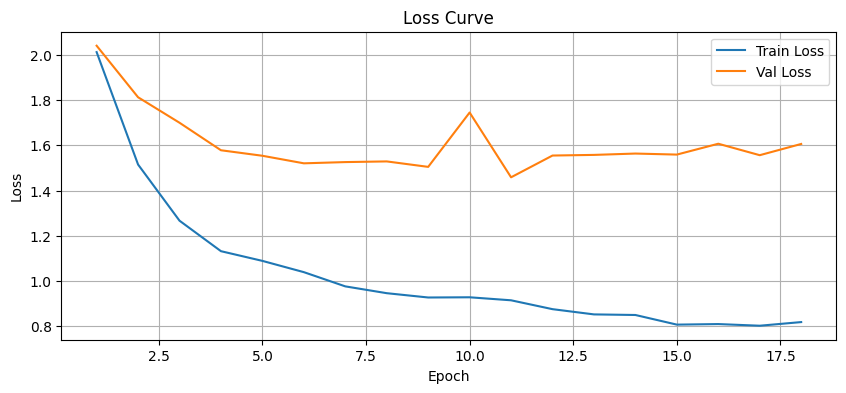

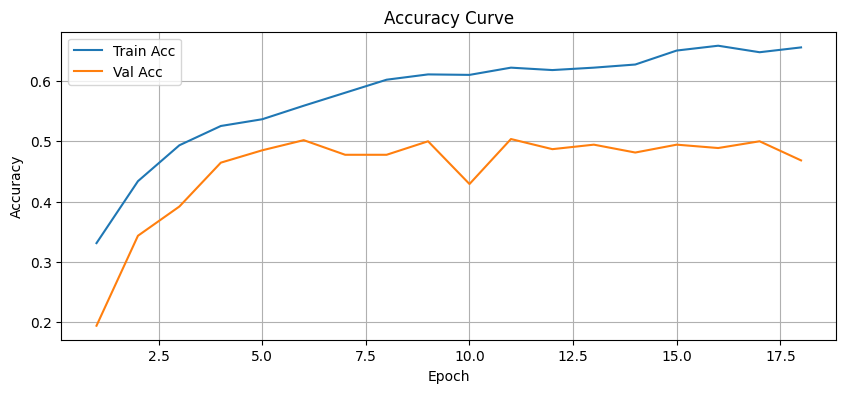

In [14]:
# ============================================
# 13. Plot Loss & Accuracy Curves
# ============================================

epochs_range = range(1, len(history["train_loss"]) + 1)

plt.figure(figsize=(10,4))
plt.plot(epochs_range, history["train_loss"], label="Train Loss")
plt.plot(epochs_range, history["val_loss"], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(10,4))
plt.plot(epochs_range, history["train_acc"], label="Train Acc")
plt.plot(epochs_range, history["val_acc"], label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy Curve")
plt.legend()
plt.grid()
plt.show()

In [15]:
# ============================================
# 14. Load Best Model for Evaluation
# ============================================

inference_model = timm.create_model(
    "efficientnet_b0",
    pretrained=False,
    num_classes=num_classes
).to(device)

inference_model.load_state_dict(torch.load(BEST_MODEL_PATH))
inference_model.eval()

print("Loaded best model.")

Loaded best model.


In [19]:
# ============================================
# 15. Evaluate on Test Set
# ============================================

all_true = []
all_pred = []

with torch.no_grad():
    for imgs, labels in tqdm(test_loader, desc="Testing"):
        imgs = imgs.to(device)
        labels = labels.to(device)

        outputs = inference_model(imgs)
        preds = outputs.argmax(1)

        all_true.extend(labels.cpu().numpy())
        all_pred.extend(preds.cpu().numpy())

test_acc = accuracy_score(all_true, all_pred)
print("✔ Test Accuracy:", test_acc)

print("\n--- Classification Report ---")
print(classification_report(
    all_true, all_pred,
    labels=list(range(num_classes)), # Explicitly pass all class labels
    target_names=[stage_names[i] for i in range(num_classes)],
    digits=3
))

Testing:   0%|          | 0/17 [00:00<?, ?it/s]

✔ Test Accuracy: 0.527001862197393

--- Classification Report ---
              precision    recall  f1-score   support

      DEBRIS      0.660     0.680     0.670       100
        Esch      0.473     0.265     0.340        98
         Gam      0.000     0.000     0.000         0
       LR-ET      0.391     0.200     0.265        45
          LT      0.442     0.339     0.384        56
        Lsch      0.476     0.588     0.526        68
          MT      0.550     0.458     0.500        48
           R      0.663     0.793     0.722        82
         Seg      0.351     0.812     0.491        32
         WBC      0.471     1.000     0.640         8

    accuracy                          0.527       537
   macro avg      0.448     0.514     0.454       537
weighted avg      0.527     0.527     0.509       537



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/me

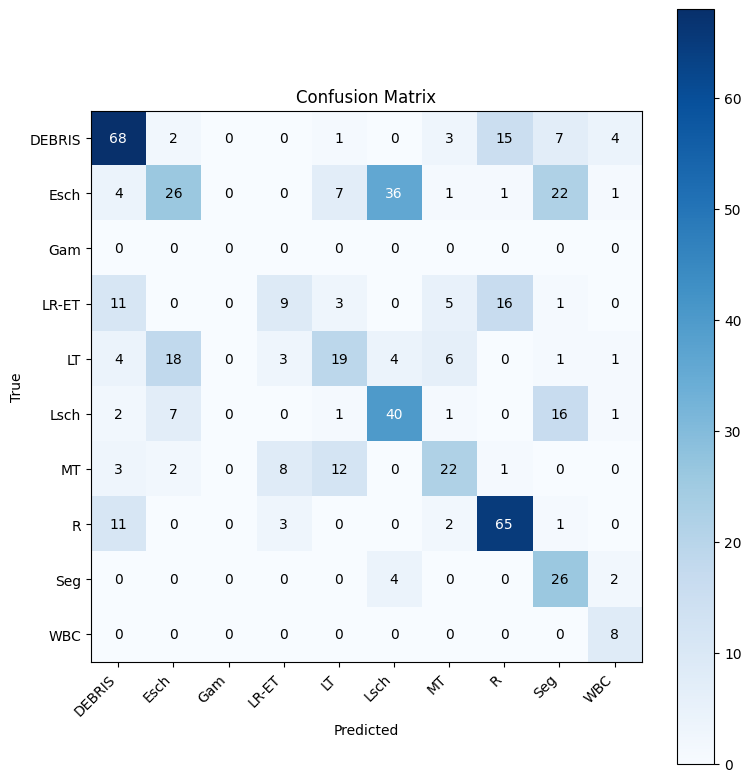

In [23]:
# ============================================
# 16. Confusion Matrix
# ============================================

# Ensure that `all_true` and `all_pred` are available from the test evaluation cell (cell "LoO-IaQQJD3o").
# Define target_names for plotting to ensure all classes are represented.
# The `labels` parameter ensures the confusion matrix includes all classes, even if some have no samples.
cm = confusion_matrix(all_true, all_pred, labels=list(range(num_classes)))

plt.figure(figsize=(8,8))
plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix")
plt.colorbar()

tick_marks = np.arange(num_classes)
plt.xticks(tick_marks, stage_names, rotation=45, ha="right")
plt.yticks(tick_marks, stage_names)

# Annotate
for i in range(num_classes):
    for j in range(num_classes):
        plt.text(j, i, cm[i,j], ha="center", va="center",
                 color="white" if cm[i,j] > cm.max()/2 else "black")

plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

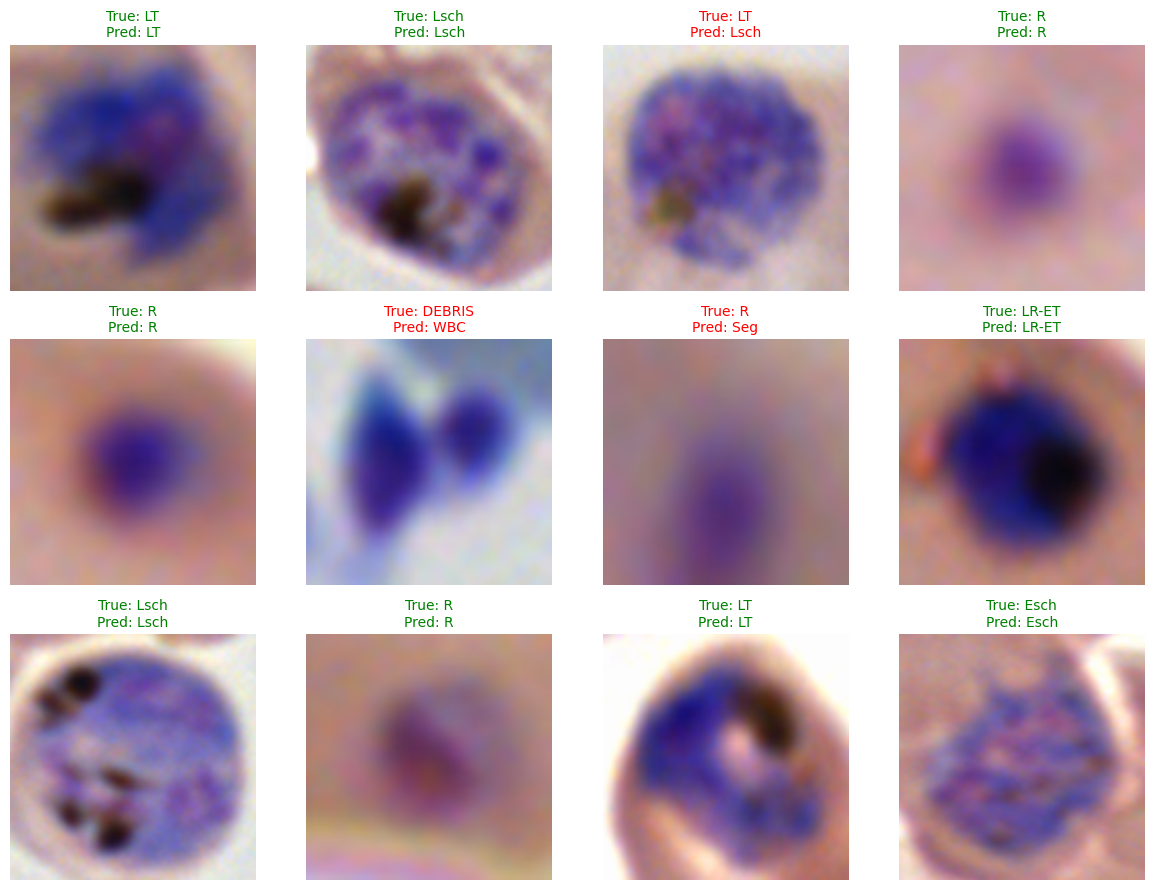

In [21]:
# ============================================
# 17. Show 12 Random Test Images With Predictions
# ============================================

def denormalize(t):
    t = t.clone().cpu().numpy()
    t = t * np.array([0.229,0.224,0.225])[:,None,None]
    t = t + np.array([0.485,0.456,0.406])[:,None,None]
    t = np.transpose(t, (1,2,0))
    return np.clip(t, 0, 1)

# Gather all images
images_list = []
true_list = []
pred_list = []

with torch.no_grad():
    for imgs, labels in test_loader:
        preds = inference_model(imgs.to(device)).argmax(1).cpu()

        images_list.append(imgs)
        true_list.append(labels)
        pred_list.append(preds)

images = torch.cat(images_list)
true_labels = torch.cat(true_list)
pred_labels = torch.cat(pred_list)

# Random 12 samples
idxs = np.random.choice(len(images), 12, replace=False)

plt.figure(figsize=(12,9))
for i, idx in enumerate(idxs):
    img = denormalize(images[idx])
    t = stage_names[int(true_labels[idx])]
    p = stage_names[int(pred_labels[idx])]

    plt.subplot(3,4,i+1)
    plt.imshow(img)
    plt.axis("off")
    color = "green" if t == p else "red"
    plt.title(f"True: {t}\nPred: {p}", color=color, fontsize=10)

plt.tight_layout()
plt.show()